# kNN-VC and LinearVC experiments using all data

Herman Kamper, 2024

In [1]:
from datetime import datetime
from numpy import linalg
from pathlib import Path
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from tqdm.notebook import tqdm
import celer
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sys
import time
import torch
import torchaudio

from utils import fast_cosine_dist

In [2]:
device = "cuda"

## Models

In [3]:
wavlm = torch.hub.load("bshall/knn-vc", "wavlm_large", trust_repo=True, device=device)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master
/home/kamperh/miniconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


WavLM-Large loaded with 315,453,120 parameters.


In [4]:
hifigan, _ = torch.hub.load("bshall/knn-vc", "hifigan_wavlm", trust_repo=True, device=device, prematched=True)

Using cache found in /home/kamperh/.cache/torch/hub/bshall_knn-vc_master


Removing weight norm...
[HiFiGAN] Generator loaded with 16,523,393 parameters.


## Single utterance

In [5]:
subset = "dev-clean"
feats_dir = Path(f"/home/kamperh/scratch/{subset}/wavlm")
wav_dir = Path(f"/home/kamperh/endgame/datasets/librispeech/LibriSpeech/{subset}")

n_frames = 8192  # 15000
k_top = 1

In [6]:
feats_dict = {}
print("Reading from:", feats_dir)
for speaker_feats_fn in tqdm(sorted(feats_dir.glob("*.npy"))):
    speaker = speaker_feats_fn.stem
    feats_dict[speaker] = np.load(speaker_feats_fn)
print("No. speakers:", len(feats_dict))

Reading from: /home/kamperh/scratch/dev-clean/wavlm


  0%|          | 0/40 [00:00<?, ?it/s]

No. speakers: 40


In [85]:
source = "1272"
target = "1462"

source_feats = feats_dict[source][:n_frames, :]
target_feats = feats_dict[target]
source_feats = torch.from_numpy(source_feats).float().to(device)
target_feats = torch.from_numpy(target_feats).float().to(device)

dists = fast_cosine_dist(source_feats, target_feats, device=device)
best = dists.topk(k=k_top, largest=False, dim=-1)
linear_target = target_feats[best.indices].mean(dim=1)

bias = None

# # Additive
# delta = torch.mean(linear_target, axis=0) - torch.mean(source_feats, axis=0)

# # Linear without bias
# W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())

# # Linear with bias
# linear = LinearRegression(fit_intercept=True).fit(
#     source_feats.cpu(), linear_target.cpu()
# )
# W = linear.coef_.T
# bias = linear.intercept_

# # Orthogonal
# W, _ = scipy.linalg.orthogonal_procrustes(source_feats.cpu(), linear_target.cpu())

# Orthogonal with bias
source_offset = np.mean(source_feats.squeeze().cpu().numpy(), axis=0)
target_offset = np.mean(linear_target.squeeze().cpu().numpy(), axis=0)
source_centred = source_feats.squeeze().cpu().numpy() - source_offset
target_centred = linear_target.squeeze().cpu().numpy() - target_offset
W, _ = scipy.linalg.orthogonal_procrustes(source_centred, target_centred)
bias = target_offset - source_offset @ W

# # Lasso
# linear = celer.Lasso(alpha=0.4, fit_intercept=False).fit(
#     source_feats.squeeze().cpu(), linear_target.cpu()
# )
# W = linear.coef_.T

In [86]:
source_wav_fn = Path("/home/kamperh/endgame/datasets/librispeech/LibriSpeech/dev-clean/1272/128104/1272-128104-0000.flac")
source_wav, _ = torchaudio.load(source_wav_fn)
display.Audio(source_wav.squeeze().cpu(), rate=16000)

In [89]:
source_wav = source_wav.to(device)
with torch.inference_mode():
    source_feats, _ = wavlm.extract_features(
        source_wav, output_layer=6
    )

# Additive
# source_to_target_feats = source_feats + delta  # additive transformation

# Linear
W_source_to_target = torch.from_numpy(W).float().to(device)
source_to_target_feats = source_feats @ W_source_to_target
if bias is not None:
    bias_source_to_target = torch.from_numpy(bias).float().to(device)
    source_to_target_feats += 1*bias_source_to_target

with torch.inference_mode():
    wav_hat = hifigan(source_to_target_feats).squeeze(0)

In [90]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)

In [12]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)  # Additive

In [13]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)  # Linear without bias

In [14]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)  # Linear with bias

In [68]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)  # Orthogonal

In [78]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)  # Orthogonal with bias

In [62]:
display.Audio(wav_hat.squeeze().cpu(), rate=16000)  # Lasso

Matrix rank: 1024
No. parameters for low rank: 2,097,152
Proportion zero: 97.37%
No. non-zero elements: 27,624 out of 1,048,576


(300.0, 0.0)

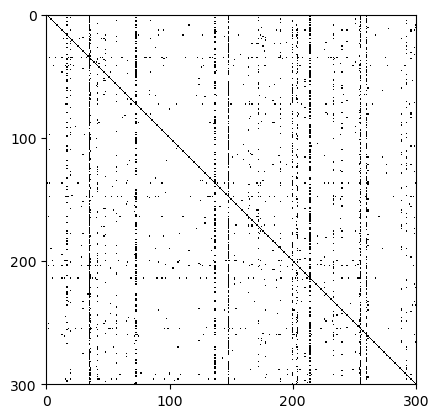

In [63]:
# Matrix properties
tol = 1e-4
print("Matrix rank:", linalg.matrix_rank(W, tol=tol))
print(
    "No. parameters for low rank: {:,d}".format(
        linalg.matrix_rank(W, tol=tol) * W.shape[0] * 2
    )
)
print(
    "Proportion zero: {:.2f}%".format(
        len(np.where(np.abs(W) < tol)[0]) / W.shape[0] ** 2 * 100
    )
)
print(
    "No. non-zero elements: {:,d} out of {:,d}".format(
        len(np.where(np.abs(W) > tol)[0]),
        W.shape[0] * W.shape[1]
    )
)

W_numpy = W.copy()
matrix = W_numpy.copy()
matrix[np.abs(matrix) < 1e-4] = 0.0
matrix[np.abs(matrix) > 1e-4] = 1.0
fig, ax = plt.subplots(1, 1)
ax.imshow(matrix.T, cmap="binary", aspect="equal", interpolation="none")

# ax.set_title(r"$\mathbf{W}^\top$")
ax.set_xticks([0, 100, 200, 300, 400, 500])
ax.set_yticks([0, 100, 200, 300, 400, 500])
ax.set_xlim([0, 300])
ax.set_ylim([300, 0])

## LinearVC (dataset)

In [3]:
# exp_tag = "2024-09-22"
# exp_tag = "2024-10-15"
# exp_tag = "2024-10-18"
# exp_tag = "2024-11-12_lasso3.0"
# exp_tag = "2024-11-12_lasso0.4"
# exp_tag = "2024-12-04_procrustes_bias"
# exp_tag = "2024-12-04_linear_bias"
# exp_tag = "2024-12-06_joint_basis"
exp_tag = "2024-12-07_linearvc_subset"

# subset = "test-clean"
subset = "dev-clean"
eval_csv = Path(f"data/speaker-sim-{subset}_subset.csv")
feats_dir = Path(f"/home/kamperh/scratch/{subset}/wavlm")
wav_dir = Path(f"/home/kamperh/endgame/datasets/librispeech/LibriSpeech/{subset}")
output_dir = Path(f"/home/kamperh/scratch/linearvc/{subset}/{exp_tag}")

n_frames = 8192  # 15000
k_top = 1

In [7]:
# temp
eval_utterances = set()
with open(eval_csv) as f:
    for line in tqdm(f.readlines()):
        line = line.strip()
        if line[-1] == "0":
            (source, target, source_key, target_key, _) = line.split(",")
            eval_utterances.add(str(Path(source_key).parent))
            eval_utterances.add(str(Path(target_key).stem))

  0%|          | 0/2401 [00:00<?, ?it/s]

In [14]:
with open(f"data/{subset}_eval_utts.txt", "w") as f:
    for line in sorted(eval_utterances):
        f.write(line + "\n")

In [26]:
output_dir.mkdir(parents=True, exist_ok=True)

In [29]:
feats_dict = {}
print("Reading from:", feats_dir)
for speaker_feats_fn in tqdm(sorted(feats_dir.glob("*.npy"))):
    speaker = speaker_feats_fn.stem
    if speaker not in ["251", "777", "1462", "1919", "1993", "2086", "3536", "6319", "7850", "8297"]:
        continue
    feats_dict[speaker] = np.load(speaker_feats_fn)
print("No. speakers:", len(feats_dict))

Reading from: /home/kamperh/scratch/dev-clean/wavlm


  0%|          | 0/40 [00:00<?, ?it/s]

No. speakers: 10


Run the two cells below or the cell that follows this (not both).

In [9]:
# Projection matrices

projmat_dir = output_dir / "projmats"
projmat_dir.mkdir(exist_ok=True, parents=True)

print("Writing to:", projmat_dir)
for source in tqdm(sorted(feats_dict)):
    for target in tqdm(sorted(feats_dict), leave=False):
        if source == target:
            continue

        npy_fn = projmat_dir / f"{source}-{target}.npy"
        if npy_fn.is_file():
            continue

        source_feats = feats_dict[source][:n_frames, :]
        target_feats = feats_dict[target]
        source_feats = torch.from_numpy(source_feats).float().to(device)
        target_feats = torch.from_numpy(target_feats).float().to(device)

        dists = fast_cosine_dist(source_feats, target_feats, device=device)
        best = dists.topk(k=k_top, largest=False, dim=-1)
        linear_target = target_feats[best.indices].mean(dim=1)

        bias = None
        
        # W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())

        # W, _ = linalg.orthogonal_procrustes(src_mat.cpu(), tgt_feats.cpu())

        # Orthogonal with bias
        source_offset = np.mean(source_feats.squeeze().cpu().numpy(), axis=0)
        target_offset = np.mean(linear_target.squeeze().cpu().numpy(), axis=0)
        source_centred = source_feats.squeeze().cpu().numpy() - source_offset
        target_centred = linear_target.squeeze().cpu().numpy() - target_offset
        W, _ = scipy.linalg.orthogonal_procrustes(source_centred, target_centred)
        bias = target_offset - source_offset @ W              

        # # Lasso
        # linear = celer.Lasso(alpha=0.4, fit_intercept=False).fit(
        #     source_feats.squeeze().cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T

        # linear = Ridge(alpha=1e4, fit_intercept=False).fit(
        #     source_feats.squeeze().cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T  

        np.save(npy_fn, W)
    
    # break

Writing to: /home/kamperh/scratch/linearvc/dev-clean/2024-11-12_lasso0.4/projmats


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
# Load projection matrices
projmats = {}
for source in tqdm(sorted(feats_dict)):
    for target in tqdm(sorted(feats_dict), leave=False):
        if source == target:
            continue
        npy_fn = projmat_dir / f"{source}-{target}.npy"
        projmats[f"{source}-{target}"] = np.load(npy_fn)
    # break

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Skip the two cells below if the above two were run.

In [30]:
# Projection matrices
projmats = {}
for source in tqdm(feats_dict):
    for target in tqdm(feats_dict, leave=False):
        if source == target:
            continue

        source_feats = feats_dict[source][:n_frames, :]
        # target_feats = feats_dict[target][:n_frames, :]
        target_feats = feats_dict[target]
        source_feats = torch.from_numpy(source_feats).float().to(device)
        target_feats = torch.from_numpy(target_feats).float().to(device)

        dists = fast_cosine_dist(source_feats, target_feats, device=device)
        best = dists.topk(k=k_top, largest=False, dim=-1)        
        linear_target = target_feats[best.indices].mean(dim=1)

        bias = None

        # # Additive
        # delta = torch.mean(linear_target, axis=0) - torch.mean(source_feats, axis=0)
        # W = None
        # bias = delta

        # Linear without bias
        W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())

        # # Linear with bias
        # linear = LinearRegression(fit_intercept=True).fit(
        #     source_feats.cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T
        # bias = linear.intercept_        

        # # Orthogonal
        # W, _ = scipy.linalg.orthogonal_procrustes(source_feats.cpu(), linear_target.cpu())

        # # Orthogonal with bias
        # source_offset = np.mean(source_feats.squeeze().cpu().numpy(), axis=0)
        # target_offset = np.mean(linear_target.squeeze().cpu().numpy(), axis=0)
        # source_centred = source_feats.squeeze().cpu().numpy() - source_offset
        # target_centred = linear_target.squeeze().cpu().numpy() - target_offset
        # W, _ = scipy.linalg.orthogonal_procrustes(source_centred, target_centred)
        # bias = target_offset - source_offset @ W        

        # # Lasso
        # linear = celer.Lasso(alpha=0.3, fit_intercept=False).fit(
        # # linear = celer.Lasso(alpha=3.0, fit_intercept=False).fit(
        #     source_feats.squeeze().cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T

        # # Ridge
        # linear = Ridge(alpha=1e4, fit_intercept=False).fit(
        #     source_feats.squeeze().cpu(), linear_target.cpu()
        # )
        # W = linear.coef_.T


        # W = torch.from_numpy(W).float().to(device)
        if bias is None:
            projmats[f"{source}-{target}"] = W
        else:
            projmats[f"{source}-{target}"] = (W, bias)
        # projmats[f"{source}-{target}"] = np.float16(W)

        # assert False
    #     break
    # break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_6993/1554450313.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W, _, _, _ = linalg.lstsq(source_feats.cpu(), linear_target.cpu())


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [2]:
output_dir.mkdir(parents=True, exist_ok=True)
npz_fn = output_dir / f"projmats_{n_frames}.npz"

print("Writing:", npz_fn)
np.savez_compressed(npz_fn, **projmats)

print("Reading:", npz_fn)
projmats = np.load(npz_fn)

In [8]:
npz_fn = "/home/kamperh/scratch/benji/transforms.npz"
print("Reading:", npz_fn)
projmats = np.load(npz_fn)
bias = None

Reading: /home/kamperh/scratch/benji/transforms.npz


In [3]:
# sizes = []
# for key in tqdm(projmats):
#     np.save(f"/home/kamperh/temp/{key}.npy", projmats[key])
#     sizes.append(Path(f"/home/kamperh/temp/{key}.npy").stat().st_size)
# print(f"Average file size: {np.mean(sizes)/1024/1024:.2f}Mb")

# # Temp
# W = projmats["1089-1188"]
# W_source_to_target = (
#     torch.from_numpy(W).float().to(device)
# )     

In [33]:
output_dir.mkdir(parents=True, exist_ok=True)
print("Writing to:", output_dir)
start_time = time.time()
new_lines = []
with open(eval_csv) as f:
    for line in tqdm(f.readlines()):
        line = line.strip()
        if line[-1] == "0":
            (source, target, source_key, _, _) = line.split(",")
            # (source, target, source_key, _, _) = line.split(",")  # VCTK

            # if f"{source}-{target}" not in projmats:
            #     continue
            # new_lines.append(line)
            
            source_key_split = source_key.split("-")
            source_wav_fn = (
                wav_dir
                / source_key_split[0]
                / source_key_split[1]
                / source_key.split("/")[0]
            ).with_suffix(".flac")
            # # VCTK
            # source_wav_fn = (
            #     wav_dir / source / Path(source_key).stem
            # ).with_suffix(".wav")
           
            source_wav, _ = torchaudio.load(source_wav_fn)
            source_wav = source_wav.to(device)
            with torch.inference_mode():
                source_feats, _ = wavlm.extract_features(
                    source_wav, output_layer=6
                )

            if bias is None:
                W_source_to_target = projmats[f"{source}-{target}"]
            else:
                W_source_to_target = projmats[f"{source}-{target}"][0]
                bias_source_to_target = projmats[f"{source}-{target}"][1]
                bias_source_to_target = torch.from_numpy(bias_source_to_target).float().to(device)
            W_source_to_target = (
                torch.from_numpy(W_source_to_target).float().to(device)
            )

            source_to_target_feats = source_feats @ W_source_to_target
            if bias is not None:
                source_to_target_feats += bias_source_to_target
           
            # source_to_target_feats = source_feats + W_source_to_target  # additive transformation

            with torch.inference_mode():
                wav_hat = hifigan(source_to_target_feats).squeeze(0)            

            cur_output_dir = Path(output_dir) / source_key.split("/")[0]
            cur_output_dir.mkdir(parents=True, exist_ok=True)
            output_fn = (cur_output_dir / source_key.split("/")[1]).with_suffix(
                ".wav"
            )
            torchaudio.save(output_fn, wav_hat.squeeze().cpu()[None], 16000)

            # print(output_fn)
            # assert False

end_time = time.time()
print(f"Time: {(end_time - start_time)/60:.2f} minutes")

Writing to: /home/kamperh/scratch/linearvc/dev-clean/2024-12-07_linearvc_subset


  0%|          | 0/2401 [00:00<?, ?it/s]

Time: 0.55 minutes


In [35]:
class Arguments: pass
args = Arguments()
args.format = "librispeech"
args.eval_csv = eval_csv
args.converted_dir = output_dir
args.groundtruth_dir = wav_dir

print("Run:")
print(
    f"./speaker_similarity.py --format {args.format}"
    f" {args.eval_csv} {args.converted_dir} {args.groundtruth_dir}"
)
print(
    f"./intelligibility.py --format {args.format} {args.converted_dir}"
    f" {args.groundtruth_dir}"
    # f" /home/kamperh/endgame/datasets/VCTK-Corpus/txt/"
)

# speaker_similarity(args)

Run:
./speaker_similarity.py --format librispeech data/speaker-sim-dev-clean_subset.csv /home/kamperh/scratch/linearvc/dev-clean/2024-12-07_linearvc_subset /home/kamperh/endgame/datasets/librispeech/LibriSpeech/dev-clean
./intelligibility.py --format librispeech /home/kamperh/scratch/linearvc/dev-clean/2024-12-07_linearvc_subset /home/kamperh/endgame/datasets/librispeech/LibriSpeech/dev-clean


Results on `test-clean`:

               eer
    mean  0.337051
    std   0.097225

    WER: 4.93% +- 0.06%
    CER: 2.55% +- 0.03%

## kNN-VC (dataset)

In [13]:
# exp_tag = "2024-09-17"
exp_tag = "2024-10-15"
subset = "test-clean"
eval_csv = Path(f"data/speaker-sim-{subset}.csv")
# eval_csv = Path("data/speakersim_vctk_english.csv")
feats_dir = Path(f"/home/kamperh/scratch/{subset}/wavlm")
wav_dir = Path(f"/home/kamperh/endgame/datasets/librispeech/LibriSpeech/{subset}")
output_dir = Path(f"/home/kamperh/scratch/knnvc/{subset}/{exp_tag}")

n_frames = None  # 15000
k_top = 4

In [14]:
feats_dict = {}
print("Reading from:", feats_dir)
sizes = []
for speaker_feats_fn in tqdm(sorted(feats_dir.glob("*.npy"))):
    speaker = speaker_feats_fn.stem
    feats_dict[speaker] = (
        torch.from_numpy(np.load(speaker_feats_fn))[:n_frames, :]
        .float()
        .to(device)
    )
    
    sizes.append(speaker_feats_fn.stat().st_size)
print("No. speakers:", len(feats_dict))
print(f"Average file size: {np.mean(sizes)/1024/1024:.2f}Mb")

Reading from: /home/kamperh/scratch/test-clean/wavlm


  0%|          | 0/40 [00:00<?, ?it/s]

No. speakers: 40
Average file size: 47.41Mb


In [15]:
output_dir.mkdir(parents=True, exist_ok=True)
print("Writing to:", output_dir)
start_time = time.time()
with open(eval_csv) as f:
    for line in tqdm(f.readlines()):
        line = line.strip()
        if line[-1] == "0":
            (source, target, source_key, _, _) = line.split(",")
            # (source, target, source_key, _, _) = line.split(",")  # VCTK

            # print(f"Time: {(time.time() - start_time):.4f} seconds")
            # start_time = time.time()
            
            source_key_split = source_key.split("-")
            source_wav_fn = (
                wav_dir
                / source_key_split[0]
                / source_key_split[1]
                / source_key.split("/")[0]
            ).with_suffix(".flac")
            # # VCTK
            # source_wav_fn = (
            #     wav_dir / source / Path(source_key).stem
            # ).with_suffix(".wav")
            
            # Features
            source_wav, _ = torchaudio.load(source_wav_fn)
            source_wav = source_wav.to(device)
            with torch.inference_mode():
                source_feats, _ = wavlm.extract_features(
                    source_wav, output_layer=6
                )
            target_feats = feats_dict[target]

            # Matching
            dists = fast_cosine_dist(
                source_feats.squeeze(), target_feats, device=device
            )
            best = dists.topk(k=k_top, largest=False, dim=-1)
            source_to_target_feats = target_feats[best.indices].mean(dim=1)[None]

            with torch.inference_mode():
                wav_hat = hifigan(source_to_target_feats).squeeze(0)            

            cur_output_dir = Path(output_dir) / source_key.split("/")[0]
            cur_output_dir.mkdir(parents=True, exist_ok=True)
            output_fn = (cur_output_dir / source_key.split("/")[1]).with_suffix(
                ".wav"
            )
            torchaudio.save(output_fn, wav_hat.squeeze().cpu()[None], 16000)

            # print(output_fn)
            # assert False

end_time = time.time()
print(f"Time: {(end_time - start_time)/60:.2f} minutes")

Writing to: /home/kamperh/scratch/knnvc/test-clean/2024-10-15


  0%|          | 0/15601 [00:00<?, ?it/s]

Time: 13.32 minutes


In [16]:
class Arguments: pass
args = Arguments()
args.format = "librispeech"
args.eval_csv = eval_csv
args.converted_dir = output_dir
args.groundtruth_dir = wav_dir

print("Run:")
print(
    f"./speaker_similarity.py --format {args.format}"
    f" {args.eval_csv} {args.converted_dir} {args.groundtruth_dir}"
)
print(
    f"./intelligibility.py --format {args.format} {args.converted_dir}"
    f" {args.groundtruth_dir}"    
    # f" /home/kamperh/endgame/datasets/VCTK-Corpus/txt/"   
)

# speaker_similarity(args)

Run:
./speaker_similarity.py --format librispeech data/speaker-sim-test-clean.csv /home/kamperh/scratch/knnvc/test-clean/2024-10-15 /home/kamperh/endgame/datasets/librispeech/LibriSpeech/test-clean
./intelligibility.py --format librispeech /home/kamperh/scratch/knnvc/test-clean/2024-10-15 /home/kamperh/endgame/datasets/librispeech/LibriSpeech/test-clean


Results:

               eer
    mean  0.389744
    std   0.094324

    WER: 5.57% +- 0.07%
    CER: 2.87% +- 0.04%